# Deploy Google Cloud Functions

In this tutorial we will show how to deploy a Google Cloud Function ([getting started](https://medium.com/@timhberry/getting-started-with-python-for-google-cloud-functions-646a8cddbb33)).

As an example we will create a function that clips an Earth Engine image and returns a download URL.

In [1]:
import json
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from IPython import display
import ee

### Clip and disply an Earth Engine image

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

In [3]:
assetId = 'Oxford/MAP/accessibility_to_cities_2015_v1_0'

In [4]:
geometry = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -11.25,
              35.02999636902566
            ],
            [
              3.69140625,
              35.02999636902566
            ],
            [
              3.69140625,
              44.84029065139799
            ],
            [
              -11.25,
              44.84029065139799
            ],
            [
              -11.25,
              35.02999636902566
            ]
          ]
        ]
      }
    }
  ]
}

geometry = json.loads(json.dumps(geometry))

In [5]:
polygon = ee.Geometry.Polygon(geometry.get('features')[0].get('geometry').get('coordinates'))
image = ee.Image(assetId).clip(ee.Geometry(polygon))

**Inspect the data**

In [6]:
def show_image(image):
      display.display(display.Image(ee.data.getThumbnail({
      'image': image.serialize(),
      'dimensions': '360'
  })))

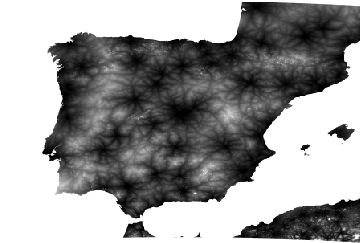

In [7]:
show_image(image.visualize(min=0,max=200))

### [Deploying Cloud Functions](https://cloud.google.com/functions/docs/deploying/console)

To create a Google Cloud Function we need a [Google Cloud Project](https://cloud.google.com/resource-manager/docs/creating-managing-projects) and [gcloud SDK](https://cloud.google.com/sdk/docs/).

If we have already some projects we can check them by typing:

`gcloud projects list`
```
PROJECT_ID        NAME                     PROJECT_NUMBER
gef-ld-toolbox    gef-ld-toolbox           1080184168142
gfw-apis          Global Forest Watch API  872868960419
resource-watch    Resource Watch           312603932249
skydipper-196010  skydipper                230510979472
soc-platform      SOC Platform             345072612231
```
and select one by:

`gcloud config set project gef-ld-toolbox`

Then create a function by creating a `main.py` file with some python code on it:

```python
import ee
import json

service_account = 'my-service-account@...gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'privatekey.json')
ee.Initialize(credentials)

def serializer(url):

    return {
        'download_url': url
    }
    
def download_image(request):
    request = request.get_json()
    
    polygon = ee.Geometry.Polygon(request['geometry'].get('features')[0].get('geometry').get('coordinates'))
    
    image = ee.Image(request['assetId']).clip(ee.Geometry(polygon))
    
    url = image.getDownloadUrl()
    
    return json.dumps(serialize_response(url))
```

In the same directory include the `privatekey.json` with the [service account keys](https://cloud.google.com/iam/docs/creating-managing-service-account-keys) and the `requirements.txt` file. 

Finally cd to that directory and deploy the cloud Function with the following command:

`gcloud beta functions deploy download_image --runtime python37 --trigger-http`

Note that the cloud function name matches the name of the function we defined in code: `download_image`.

### [Calling Cloud Functions](https://cloud.google.com/functions/docs/calling/)

You can invoke Cloud Functions with an HTTP request using the POST, PUT, GET, DELETE, and OPTIONS HTTP methods. To find the `URL` that triggers the function open the details of the created function and click on the `Trigger` tab.

In [8]:
payload =   {
    "assetId": "Oxford/MAP/accessibility_to_cities_2015_v1_0",
    "geometry": {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                          -11.25,
                          35.02999636902566
                        ],
                        [
                          3.69140625,
                          35.02999636902566
                        ],
                        [
                          3.69140625,
                          44.84029065139799
                        ],
                        [
                          -11.25,
                          44.84029065139799
                        ],
                        [
                          -11.25,
                          35.02999636902566
                        ]
                    ]
                ]
            }
        }
        ]
    }
}

In [9]:
url = f'https://us-central1-bucket-name.cloudfunctions.net/download_image'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
pprint(r.json())

{'download_url': 'https://earthengine.googleapis.com/api/download?docid=2a2dfcbbf18a82d4225926c9d6f3dcbc&token=6ead9098f2269d605de3c89e833ef016'}


Then we can paste the `download_url` link into a browser address bar to get the `.zip` file that contains the image.

### Load data 

In [32]:
# Load tiff file data
with rasterio.open('/Users/ikersanchez/Downloads/accessibility_to_cities_2015_v1_0/accessibility_to_cities_2015_v1_0.accessibility.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


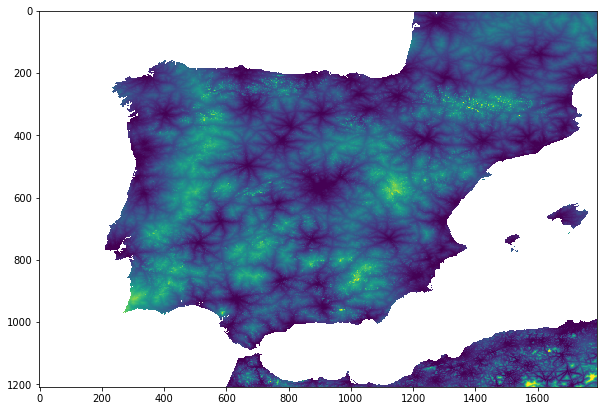

In [36]:
data = data.astype(float)
data[data==data.min()]=np.nan
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(data[0,:,:], vmax=200);